***Домашнее задание #4. Применение бертоподобных моделей к задаче классификации***

Решите задачу классификации по тональности на подготовленном в тетрадке корпусе, используя пайплайн с Trainer  от HuggingFace. 



1. обучите ту модель, которую мы разбирали на занятии (класс SentimentClassifier из тетрадки) -- 2 балла 

In [1]:
!pip install -q -U watermark

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [2]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 33.4 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 6.5 MB 33.8 MB/s 
     |████████████████████████████████| 895 kB 39.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.21.5
pandas      : 1.3.5
torch       : 1.10.0+cu111
transformers: 4.17.0



In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 74.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 74.5MB/s]


In [5]:
import transformers
from transformers import BertModel, AutoTokenizer, BertTokenizer, PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [7]:
df = pd.read_csv("reviews.csv")

In [8]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

In [9]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [10]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


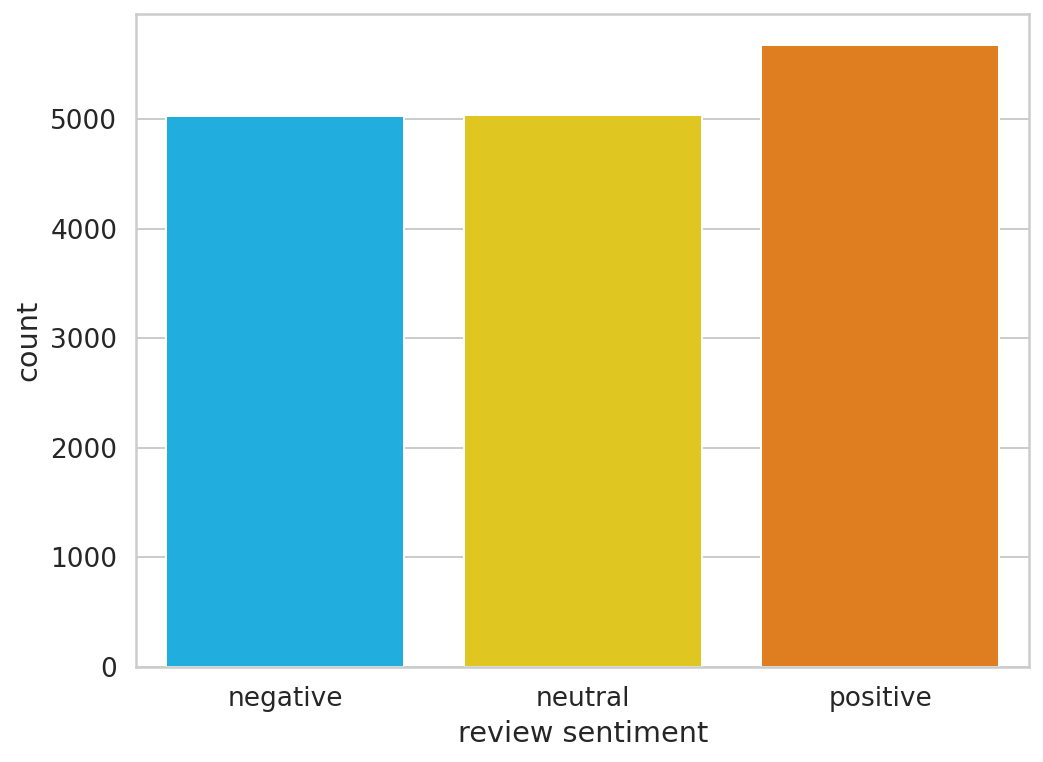

In [11]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [13]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [55]:
X = list(df["content"])
y = list(df["sentiment"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=160)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=160)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=160)

In [15]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [44]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized, y_val)

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [18]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.drop(pooled_output)
    
    return self.out(output)

In [30]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import TrainingArguments, Trainer
from torch.nn import CrossEntropyLoss

In [20]:
model = SentimentClassifier(len(class_names))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred,average='weighted' )
    precision = precision_score(y_true=labels, y_pred=pred,average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred,average='weighted')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [32]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Создаем кастомный трейнер для обучения, поскольку обычный выводит ошибку, так как принимаем логиты за лосс:

In [33]:
class MyTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        if "labels" in inputs:
          labels = inputs.pop("labels")
        
        outputs = model(**inputs)
        logits = outputs
        loss_function = nn.CrossEntropyLoss()

        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = loss_function(logits, labels)
        else:
            # We don't use .loss here since the model may return tuples instead of ModelOutput.
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

        return (loss, outputs) if return_outputs else loss

In [34]:
trainer = MyTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 14171
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1772


Step,Training Loss
500,0.799800
1000,0.655700
1500,0.468400


Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1772, training_loss=0.6058258891912939, metrics={'train_runtime': 1610.853, 'train_samples_per_second': 17.594, 'train_steps_per_second': 1.1, 'total_flos': 0.0, 'train_loss': 0.6058258891912939, 'epoch': 2.0})

Сделаем предсказания на тестовом датасете:

In [56]:
test_dataset = Dataset(X_test_tokenized)

In [57]:
model_path = "results/checkpoint-1500"

# Define test trainer
test_trainer = MyTrainer(model)

# Make prediction

raw_pred, _, _ = test_trainer.predict(test_dataset)


# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 788
  Batch size = 8


In [58]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred,average='weighted' )
precision = precision_score(y_true=y_test, y_pred=y_pred,average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_pred,average='weighted')
print('ACCURACY: ' + str(accuracy))
print('RECALL: ' + str(recall))
print('PRECISION: ' + str(precision))
print('F1: ' + str(f1))

ACCURACY: 0.9175126903553299
RECALL: 0.9175126903553299
PRECISION: 0.9183037130783537
F1: 0.9177737389200354


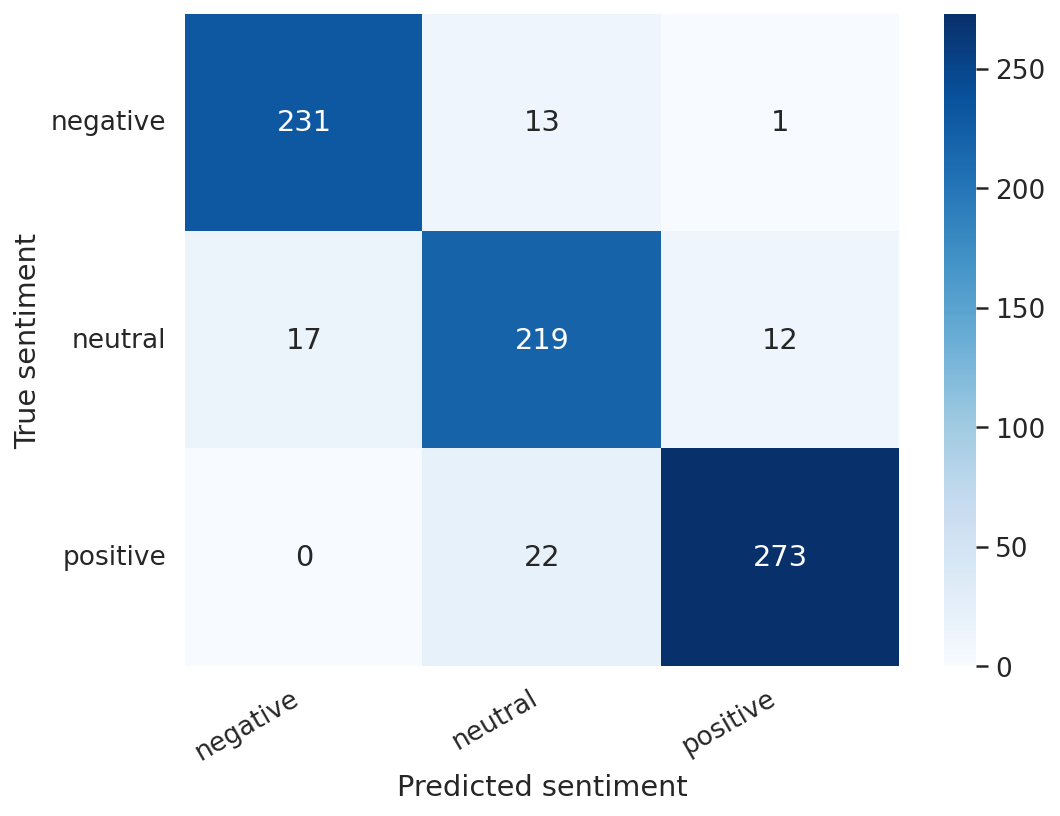

In [59]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Анализируя матрицу ошибок, можно сказать, что модель не всегда правильно определяет средний класс: иногда относит к положительным или отрицательным, что в целом нормально.

Также возьмем четыре отзыва из гугл-плей:

The whole game is ruined with the PR system. You upgrade parts and the PR doesn't increase? You win mystery parts but never get what you need and it just wastes the days on special events so they never get completed! I know you want to make money but you've ruined what could potentially be a very go

Оценка на гугл-плей: 2

Good game. Please add multiplayer mode so we can play with friends. It will be much fun if we can play with our friendlist than random live player.

Оценка на гугл-плей: 5

Convoluted rewards and parts system. The game is far too difficult to setup and understand before you can get to a race. A never-ending confusion of terms such as money, gold, parts, black market, etc. Gone are the days when NFS was just about selecting a car and selecting a track to race on. On the PC it was an amazing experience until NFS MW. Now it's just all monetized garbage and again, hate to say it again, VERY complicated to understand how to start a race.

Оценка на гугл-плей: 1

The reason I'm giving three stars to this game. It's because of its VIP in game system. You purchased bundle pack on the game and it throws out Ads. Every time you a win race in the game. Majority of the games I play don't shows Ads after you purchased a pack or bundle. The fuel system in this game so I can play more into this game is somewhat lacking. It should of gave you additional tickets for the other races like those you have a certain time to complete.

Оценка на гугл-плей: 3

In [60]:
first_review = "The whole game is ruined with the PR system. You upgrade parts and the PR doesn't increase? You win mystery parts but never get what you need and it just wastes the days on special events so they never get completed! I know you want to make money but you've ruined what could potentially be a very go"

In [61]:
second_review = "Good game. Please add multiplayer mode so we can play with friends. It will be much fun if we can play with our friendlist than random live player."

In [62]:
third_review = "Convoluted rewards and parts system. The game is far too difficult to setup and understand before you can get to a race. A never-ending confusion of terms such as money, gold, parts, black market, etc. Gone are the days when NFS was just about selecting a car and selecting a track to race on. On the PC it was an amazing experience until NFS MW. Now it's just all monetized garbage and again, hate to say it again, VERY complicated to understand how to start a race."

In [63]:
fourth_review = "The reason I'm giving three stars to this game. It's because of its VIP in game system. You purchased bundle pack on the game and it throws out Ads. Every time you a win race in the game. Majority of the games I play don't shows Ads after you purchased a pack or bundle. The fuel system in this game so I can play more into this game is somewhat lacking. It should of gave you additional tickets for the other races like those you have a certain time to complete."

In [122]:
all_reviews = [first_review, second_review, third_review, fourth_review]

In [127]:
text_tokenized = tokenizer(all_reviews, padding=True, truncation=True, max_length=160)
data = Dataset(text_tokenized)

In [128]:
model_path = "results/checkpoint-1500"

# Define test trainer
test_trainer = MyTrainer(model)

# Make prediction

raw_pred, _, _ = test_trainer.predict(data)


# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 4
  Batch size = 8


In [130]:
print(f'Review text: {all_reviews[0]}')
print(f'Sentiment  : {class_names[y_pred[0]]}')

Review text: The whole game is ruined with the PR system. You upgrade parts and the PR doesn't increase? You win mystery parts but never get what you need and it just wastes the days on special events so they never get completed! I know you want to make money but you've ruined what could potentially be a very go
Sentiment  : negative


In [131]:
print(f'Review text: {all_reviews[1]}')
print(f'Sentiment  : {class_names[y_pred[1]]}')

Review text: Good game. Please add multiplayer mode so we can play with friends. It will be much fun if we can play with our friendlist than random live player.
Sentiment  : positive


In [132]:
print(f'Review text: {all_reviews[2]}')
print(f'Sentiment  : {class_names[y_pred[2]]}')

Review text: Convoluted rewards and parts system. The game is far too difficult to setup and understand before you can get to a race. A never-ending confusion of terms such as money, gold, parts, black market, etc. Gone are the days when NFS was just about selecting a car and selecting a track to race on. On the PC it was an amazing experience until NFS MW. Now it's just all monetized garbage and again, hate to say it again, VERY complicated to understand how to start a race.
Sentiment  : negative


In [134]:
print(f'Review text: {all_reviews[3]}')
print(f'Sentiment  : {class_names[y_pred[3]]}')

Review text: The reason I'm giving three stars to this game. It's because of its VIP in game system. You purchased bundle pack on the game and it throws out Ads. Every time you a win race in the game. Majority of the games I play don't shows Ads after you purchased a pack or bundle. The fuel system in this game so I can play more into this game is somewhat lacking. It should of gave you additional tickets for the other races like those you have a certain time to complete.
Sentiment  : neutral


Как мы видим: модель хорошо справилась с классификацией отзывов и везде попала в точку.